In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context('notebook', font_scale=1.3)
sns.set_palette('tab10')
sns.set_style('white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from glob import glob
import json

# fn = "../julia/" + "runs/rando/results/simulation-3-3.199002557439509-0.002350996666308146-7.700057150705852-100-1000-0-rando.json"
# fn = "../julia/" + "runs/rando/results/simulation_zero-3-3.2977443232221635-0.004421845867169682-5.4492245780315205-100-1000-0-rando.json"
fn = "../julia/" + "runs/rando/results/simulation_empirical-3-3.199002557439509-0.002350996666308146-7.700057150705852-100-1000-0-rando.json"
with open(fn) as f:
    d = json.load(f)

In [3]:
hdf = pd.read_csv('../krajbich_PNAS_2011/trials.csv')
import json
for c in 'value', 'fixations', 'fix_times':
    hdf[c] = hdf[c].apply(json.loads)
hdf['rt'] = hdf.fix_times.apply(sum)

mdf = pd.DataFrame(d['value'])
mdf.rename(columns={'fixations': 'focused'}, inplace=True)
# mdf.value = hdf.value

In [4]:
n_step = mdf.focused.apply(len)
time_per_step = hdf.rt.mean() / n_step.mean()
print('miliseconds per step', time_per_step)
mdf['rt'] = n_step * time_per_step

miliseconds per step 83.86180662900777


In [66]:
for c in 'value', 'fixations', 'fix_times':
    hdf[c] = hdf[c].apply(np.array)

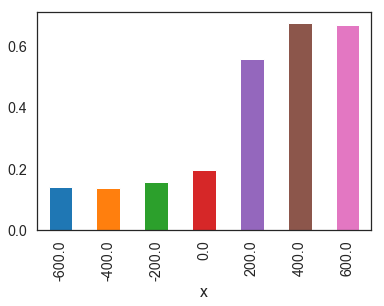

In [52]:
fix_times = mdf.focused.apply(lambda x: np.bincount(x, minlength=4)[1:] * time_per_step)
X = np.stack(fix_times.values)
x = X[:, 0] - X[:, 1:2].mean(1)
y = mdf.choice == 1
bins = pd.cut(x, np.arange(-700, 701, 200)).map(lambda x: x.mid)
pd.DataFrame({'x': bins, 'y':y}).dropna().groupby('x').y.mean().plot.bar()

In [33]:

hdf['agent'] = 'Human'
mdf['agent'] = 'Model'

mdf['n_fix'] = mdf.focused.apply(lambda x: np.sum(np.diff(x) != 0) + 1)
hdf['n_fix'] = hdf.fixations.apply(len)

df = pd.concat([mdf, hdf], sort=False).dropna(axis=1)

array([754.75625966,   0.        ,  83.86180663, ..., 587.0326464 ,
        83.86180663, 251.58541989])

In [5]:
hdf['agent'] = 'Human'
mdf['agent'] = 'Model'

mdf['n_fix'] = mdf.focused.apply(lambda x: np.sum(np.diff(x) != 0) + 1)
hdf['n_fix'] = hdf.fixations.apply(len)

df = pd.concat([mdf, hdf], sort=False).dropna(axis=1)

In [167]:
df_value = np.stack(df.value)
df['value_max'] = df_value.max(1)
df['value_min'] = df_value.min(1)
df['value_mean'] = df_value.mean(1)
df['value_std'] = df_value.std(1)
df['choice_value'] = df_value[np.arange(len(df)), df.choice.values - 1]
# cutoff = df.n_step.quantile(0.99)
# df = df.query('n_step < @cutoff').copy()
df['loss'] = df.value_max - df.choice_value
df['error'] = df.loss > 0

In [168]:
V = np.stack(hdf.value)
def softmax(x, temp=1):
    ex = np.exp((x - x.max(-1, keepdims=True)) / temp)
    return ex / ex.sum(-1, keepdims=True)

def log_likelihood(temp):
    P = softmax(V, temp)
    return np.log(P[np.arange(len(hdf)), hdf.choice.values - 1]).mean()

temps = np.linspace(0.2,5)
logps = [log_likelihood(t) for t in temps]
best_temp = temps[np.argmax(logps)]
from scipy.stats import multinomial
P = softmax(V, temp=best_temp)
softmax_choices = [np.random.choice(3, p=p) for p in P]
softmax_choice_value = V[np.arange(len(V)), softmax_choices]

# Match human plots

In [169]:
# hdf = pd.read_pickle('data/human_trials')
# cutoff = hdf.rt.quantile(0.99)
# hdf = hdf.query('rt < @cutoff')
# hdf.rt /= 1000

In [170]:
def plot(func, data=df):
    g = sns.FacetGrid(data, col='agent')
    g.map_dataframe(func)
    g.set_titles('{col_name}')
    return g

def save(name):
    plt.tight_layout(pad=1.15)
    plt.savefig(f'figs/{name}.pdf')

## Choice quality

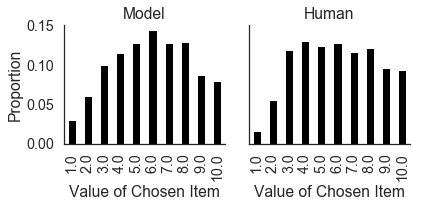

In [193]:
def f(data, **kwargs):    
    vc = data.choice_value.value_counts().sort_index()
    vc /= vc.sum()
    vc.plot.bar(color='k')
#     plt.axhline(tdf.rt.mean(), ls='--')
plot(f).set_axis_labels('Value of Chosen Item', 'Proportion')
save('choice_value')

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


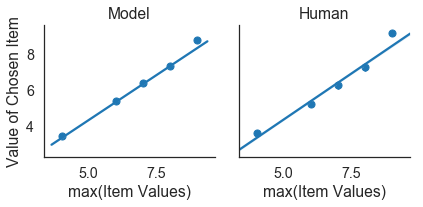

In [172]:
def f(data, **kwargs):    
    sns.regplot('value_max', 'choice_value', data=data, x_bins=5, ci=95)
#     plt.plot([1,10], [1, 10], c='k', alpha=0.4)
#     plt.axhline(tdf.rt.mean(), ls='--')
plot(f).set_axis_labels('max(Item Values)', 'Value of Chosen Item')
save('choice_value_max')

## Number of fixations

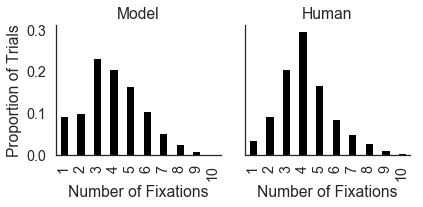

In [177]:
def n_fix(data, **kwargs):
    vc = data.n_fix.value_counts().sort_index()
    vc /= vc.sum()
    vc = vc.loc[1:10]
    vc.plot.bar(color='k')
    plt.xlabel('Number of Fixations')
    plt.ylabel('Proportion of Trials')

plot(n_fix).set_axis_labels('Number of Fixations', 'Proportion of Trials')
save('nfix')

In [185]:
def f(data, **kwargs):
    sns.regplot('value_mean', 'n_fix', data=data, x_bins=10,)

# plot(f).set_axis_labels('mean(Item Values)', 'Number of Fixations')

## Reaction time

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


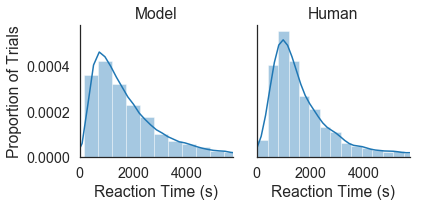

In [187]:
def f(data, **kwargs):
    sns.distplot(data.rt)
    plt.xlim(0, hdf.rt.quantile(0.95))
    # plt.axvline(tdf.rt.mean(), ls='--')

plot(f).set_axis_labels('Reaction Time (s)', 'Proportion of Trials')
plt.tight_layout(pad=1.2)
save('rt')

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


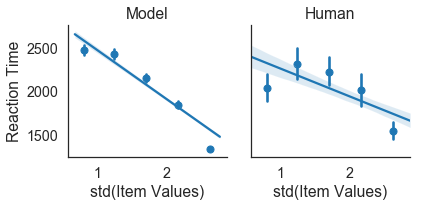

In [188]:
def f(data, **kwargs):    
    sns.regplot('value_std', 'rt', data=data, x_bins=5, ci=95)
#     plt.axhline(tdf.rt.mean(), ls='--')
plot(f).set_axis_labels('std(Item Values)', 'Reaction Time')
save('rt_value_std')

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


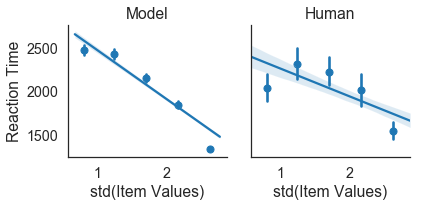

In [188]:
def f(data, **kwargs):    
    sns.regplot('value_std', 'rt', data=data, x_bins=5, ci=95)
#     plt.axhline(tdf.rt.mean(), ls='--')
plot(f).set_axis_labels('std(Item Values)', 'Reaction Time')
save('rt_value_std')

In [191]:
def f(data, **kwargs):    
    sns.regplot('value_mean', 'rt', data=data, x_bins=5, ci=95)
#     plt.axhline(tdf.rt.mean(), ls='--')
  
# plot(f).set_axis_labels('mean(Item Values)', 'Reaction Time')
# # plot(f, tdf.query('value_std < 0.5')
#     ).set_axis_labels('mean(Item Values)', 'Reaction Time')
# save('value_mean')

## Attention

In [182]:
from toolz import concat

def focus_ranks(row):
    ranks = np.argsort(-np.array(row['value'])) + 1
    return ranks[np.array(row['focused'])-1]


model_ranks = pd.DataFrame(list(concat(enumerate(focus_ranks(row)) for i, row in mdf.iterrows())),
                     columns=['step', 'focus'])

human_ranks = pd.read_csv('../krajbich_PNAS_2011/discretized_fixations.csv')
# human_ranks.step -= 1 # julia is 1-indexed
# human_ranks.focus_rank = human_ranks.focus_rank.astype(int)
# human_ranks.time /= 1000
human_ranks['agent'] = 'Human'
model_ranks['agent'] = 'Model'
model_ranks['time'] = model_ranks.pop('step') * time_per_step
# human_ranks['time'] = human_ranks.pop('step') * 50

ranks = pd.concat([human_ranks, model_ranks], sort=False)

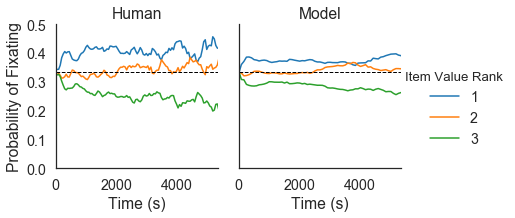

In [183]:
rt_cutoff = df.rt.quantile(0.95)
def f(data, **kwargs):
    n_step = data.groupby(['focus', 'time']).apply(len)
    p_step = n_step / n_step.sum(level=1)
    p_step.unstack().T.plot(ax=plt.gca())
    max_x = (human_ranks.time.value_counts() > 100).idxmin()
    plt.xlim(0,rt_cutoff)
    plt.axhline(1/3, c='k', lw=1, ls='--')
    plt.ylim(0, 0.5)

g = plot(f, data=ranks)
g.set_axis_labels('Time (s)', 'Probability of Fixating')
g.add_legend(title='Item Value Rank')
plt.subplots_adjust(bottom=0.2, left=0.15)
plt.savefig('figs/prob_fix.pdf')

# Old

In [173]:
def data():
    for t in mdf.itertuples():
        yield {'advantage': sum(np.array(t.focused) == 1) - (len(t.focused) / 3),
               'choice': t.choice == 1}

def data():
    for t in hdf.itertuples():
        yield {'advantage': sum(np.array(t.fix_times)[np.array(t.fixations) == 1]) - (sum(t.fixations) / 3),
               'choice': t.choice == 1}
# pd.DataFrame(data())

In [ ]:
n_step = ranks.groupby(['focus', 'step']).apply(len)
p_step = n_step / n_step.sum(level=1)
p_step.unstack().T.plot()
plt.xlim(0,50)
plt.ylim(0, 1)
# plt.xlim(0, (n_step.sum(level='step') < 100).argmax())
plt.title('Model')
plt.xlabel('Time')
plt.ylabel('Probability of Fixating')
plt.axhline(1/3, c='k', lw=1, ls='--')

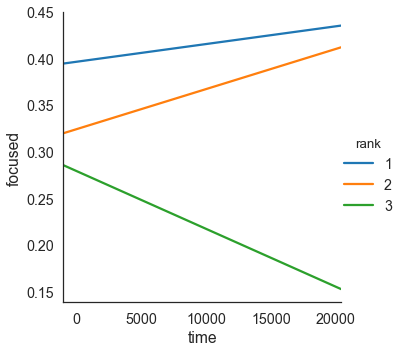

In [99]:
dd = pd.melt(pd.get_dummies(human_ranks, columns=['focus']), id_vars=['time', 'agent'], var_name='rank', value_name='focused')
dd['rank'] = dd['rank'].str[-1]
sns.lmplot('time', 'focused', hue='rank', data=dd, scatter=False, ci=None)

In [100]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
mod = smf.glm('focused ~ time * rank', family=sm.families.Binomial(), data=dd)
mod.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                focused   No. Observations:               353901
Model:                            GLM   Df Residuals:                   353895
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.2285e+05
Date:                Tue, 22 Jan 2019   Deviance:                   4.4570e+05
Time:                        16:32:15   Pearson chi2:                 3.54e+05
No. Iterations:                     5   Covariance Type:             nonrobust
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4198      0.008    -54.441      0.000      -0.435      -0.405
rank[T.2]         -0.3139      0.011    -28.212      0.000      -0.336      -0.292
rank[T.3]         -0.5267      0.012    -45.758      0.000      -0.549      -0.504
time            7.881e-06   2.69e-06      2.928      0.003    2.61e-06    1.32e-05
time:rank[T.2]  1.119e-05   3.86e-06      2.898      0.004    3.62e-06    1.88e-05
time:rank[T.3] -4.093e-05   4.13e-06     -9.912      0.000    -4.9e-05   -3.28e-05
==================================================================================
"""

## Stats

In [7]:
import statsmodels.formula.api as smf
def ols(formula):
    return smf.ols(formula, data=df).fit().summary().tables[1]

In [ ]:
ols('n_step ~  value_std')

In [ ]:
ols('n_step ~ value_max + value_std')

In [ ]:
ols('n_step ~ value_mean * switch_cost')